# EDUS_2.0 HDF5 parser

## Initialization, first imports

### kernel definitions

{KernelObject[1, Local (16)], KernelObject[2, Local (16)], KernelObject[3, Local (16)], 
 
>   KernelObject[4, Local (16)], KernelObject[5, Local (16)], 
 
>   KernelObject[6, Local (16)], KernelObject[7, Local (16)], 
 
>   KernelObject[8, Local (16)], KernelObject[9, Local (16)], 
 
>   KernelObject[10, Local (16)], KernelObject[11, Local (16)], 
 
>   KernelObject[12, Local (16)], KernelObject[13, Local (16)], 
 
>   KernelObject[14, Local (16)], KernelObject[15, Local (16)], 
 
>   KernelObject[16, Local (16)]}
{Null, Null, Null, Null, Null, Null, Null, Null, Null, Null, Null, Null, Null, Null, 
 
>   Null, Null}
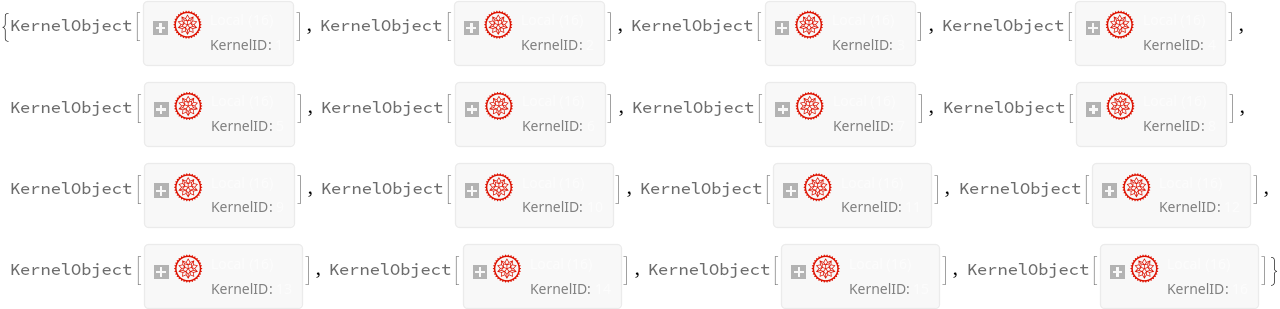

In [1]:

LaunchKernels[16]

ParallelEvaluate[
  $HistoryLength = 0; 
  SetSystemOptions["CacheOptions" -> {"Numeric" -> {"Cache" -> False}, "Symbolic" -> {"Cache" -> False}}]; 
 ]

Needs["GeneralUtilities`"]

ClearSystemCache[]
$HistoryLength = 0;
SetSystemOptions["CacheOptions" -> {"Numeric" -> {"Cache" -> False}, "Symbolic" -> {"Cache" -> False}}];

<< MaTeX`
texStyle = {FontFamily -> "CMU Serif", FontColor -> Black, FontSize -> 22};
SetOptions[MaTeX, "Preamble" -> {"\\usepackage{amsmath,amssymb}", "\\usepackage{xcolor,color}"}];
MaTLabel[text_, size_] := Style[MaTeX[text, FontSize -> size]];
 
$Assumptions = k \[Element] PositiveReals;

### initial h5 read

In [18]:
tt = "/mnt/4TB/EDUS_2.0/Postproces/output.h5";

(*h5 = Import[tt];*)

Import[tt, "/json/laser0/"]

(*h5clean = Last /@ Sort[{ToExpression[StringJoin[Select[Characters@#, DigitQ]]], #} & /@ h5];*)

6
<|cycles -> {1}, frequency -> {5.}, intensity -> {1. 10 }, polarization -> {1}, 
 
                             10
>   wavelength -> {1.02514 10  }|>

### preview laser pulse and its Fourier transform

In [ ]:
laser = Import["/run/media/mauricioquintela/easystore/work/results/raman/raman2-1e15/simulation/Output/Laser.txt", "Data"];
time = 0.024188843*10^-15*Import["/run/media/mauricioquintela/easystore/work/results/raman/raman2-1e15/simulation/Output/Time.txt", "Data"];
et = Table[{10^15 time[[i, 1]], laser[[i, 3]]}, {i, 1, Length[time]}];

IFT[(w_)?NumberQ, vals_, times_] := Total[vals*Exp[(- I)*w*times]]/Length[times]

width = 2*Import[tt, "/json/laser0/frequency"][[1]]/Import[tt, "/json/laser0/cycles"][[1]];

Row[{
  Plot[
  Abs[IFT[(2 \[Pi] w)/( 4.13558 *10^-15), laser[[All, 3]], time[[All, 1]]]]
  , {w, Import[tt, "/json/laser0/frequency"][[1]] - 3 width, Import[tt, "/json/laser0/frequency"][[1]] + 3 width}, 
   PlotRange -> {All, All}, ImageSize -> 400, Frame -> True,
   Epilog -> {
     Directive[Red], 
     Point[{Import[tt, "/json/laser0/frequency"][[1]] - width, 0}], 
     Point[{Import[tt, "/json/laser0/frequency"][[1]] + width, 0}],
     Directive[Darker@Green], 
     Point[{Import[tt, "/json/laser0/frequency"][[1]] - 2 width, 0}], 
     Point[{Import[tt, "/json/laser0/frequency"][[1]] + 2 width, 0}]
     }
   ],
  ListLinePlot[et, PlotRange -> {{0, 1}, All}, ImageSize -> 400, 
   Frame -> True],
  Module[{\[Omega], n},
   \[Omega] = 
    241799050402417/10^15*Import[tt, "/json/laser0/frequency"][[1]] ;
   n = Import[tt, "/json/laser0/cycles"][[1]];
   Show[{Plot[
      Sin[2 \[Pi] \[Omega] t] Sin[\[Pi] t/(n*1/\[Omega])]^2, {t, 0, 1},
       PlotRange -> {{0, 1}, All}, ImageSize -> 400, Frame -> True], 
     ListLinePlot[et /. {x_, y_} -> {x, y/Max[laser[[All, 3]]]}, 
      PlotRange -> {{0, 1}, All}, ImageSize -> 400, Frame -> True, 
      PlotStyle -> Red]}]
   ]
  }]


### read lattice and reciprocal vectors from h5 file

In [ ]:
(*\[Delta] = Norm@{0.721684, 1.25};
Norm[{3/2, Sqrt[3]/2}*\[Delta]]
bb1 = Solve[{{a, b} . {3/2, Sqrt[3]/2} == 2 \[Pi], {a, b} . {3/2, -(Sqrt[3]/2)} == 0}, {a, b}]; 
bb2 = Solve[{{a, b} . {3/2, -(Sqrt[3]/2)} == 2 \[Pi], {a, b} . {3/2, Sqrt[3]/2} == 0}, {a, b}];

bb1vec = {bb1[[1, 1, 2]], bb1[[1, 2, 2]], 0}/\[Delta]; 
bb2vec = {bb2[[1, 1, 2]], bb2[[1, 2, 2]], 0}/\[Delta];*)
autoang[x_] = 0.529177249 x;
SetAttributed[autoang,Listable];
AVecs=autoang@Transpose@Partition[Import[tt,"/json/A"],3];
BVecs=Transpose@Partition[Import[tt,"/json/B"],3];

bb1vec = BVecs[[1]]; 
bb2vec = BVecs[[2]];
  
Kk1 = 1/3 (bb1vec - bb2vec); Kk2 = 1/3 (bb2vec - bb1vec);

KM1 = Simplify[bb1vec/2]; KM2 = Simplify[(bb1vec + bb2vec)/2];

corner1 = Simplify[(bb1vec + bb2vec)/2]; 
corner2 = Simplify[-((bb1vec + bb2vec)/2)]; 
corner3 = Simplify[(bb1vec - bb2vec)/2];
corner4 = Simplify[-((bb1vec - bb2vec)/2)];

shift = {
   {0, 0, 0},
   2 corner2,
   corner2 + corner3,
   corner2 + corner4
   };

lattice = Graphics[{
    Red, Thickness[0.012],
    Line[{corner1, corner3}] /. {x_, y_, z_} -> {x, y},
    Line[{corner2, corner3}] /. {x_, y_, z_} -> {x, y},
    Line[{corner2, corner4}] /. {x_, y_, z_} -> {x, y},
    Line[{corner4, corner1}] /. {x_, y_, z_} -> {x, y},
    Darker@Green, PointSize[0.025],
    Point[Kk1] /. {x_, y_, z_} -> {x, y}, 
    Point[Kk2] /. {x_, y_, z_} -> {x, y},
    Lighter[Blue],
    Point[KM1] /. {x_, y_, z_} -> {x, y}, 
    Point[KM2] /. {x_, y_, z_} -> {x, y},
    LightBlue,
    Point[{0, 0}]
    }];

### simple reads from h5

In [31]:
numkpts = Import[tt, "/json/num_kpoints"][[1]];
numbands = Import[tt, "/json/num_bands"][[1]];
ncom = Import[tt, "/json/comm_size"][[1]];

kpts = Partition[Import[tt, "/json/kpoints"], 3];
kptstrans = Table[{(kpts[[i, 1]]*bb1vec + kpts[[i, 2]]*bb2vec)[[1]], (kpts[[i, 1]]*bb1vec + kpts[[i, 2]]*bb2vec)[[2]]}, {i, 1, Length[kpts]}];

### defining print time steps and plot steps

In [ ]:
printsteps = Length[Import[tt, "time_au"]]
plotsteps = 20;

timetab = Table[Flatten@{step, Import[tt, "time_au/" <> ToString[step]]}, {step, 0, printsteps - 1, plotsteps}];

Length@timetab

## DensityMatrix_k

### DensityMatrix_k in time steps

In [50]:
densmat = ParallelTable[Flatten[Table[Import[tt, "DensityMatrix_k/" <> ToString[step] <> "/" <> ToString[i - 1] <> "/local"], {i, 1, ncom}]], {step, timetab[[All, 1]]}]; // AbsoluteTiming
reimdensmat = ParallelTable[Partition[densmat[[step]], 2] /. {x_, y_} -> {x + I y}, {step, 1, Length[densmat]}]; // AbsoluteTiming
reshapeddensmat = ArrayReshape[reimdensmat, {Length[densmat], numkpts, numbands, numbands}]; // AbsoluteTiming
absdenmat = Abs@reshapeddensmat; // AbsoluteTiming

Length[reshapeddensmat]

11

### tiled DensityMatrix_k

In [ ]:
tiled = ParallelTable[
Module[{popkptscond}, 
     popkptscond[a_, b_] := Table[{kptstrans[[i, 1]], kptstrans[[i, 2]], absdenmat[[step]][[i, a, b]]}, {i, 1, Length[kpts]}]; 
     Table[Flatten[Table[popkptscond[a, b] + Threaded[shift[[i]]], {i, 1, Length[shift]}],1], {a, 1, numbands}, {b, 1, numbands}] 
    ]
    , {step, 1, Length[densmat]}];

 

-Graphics-
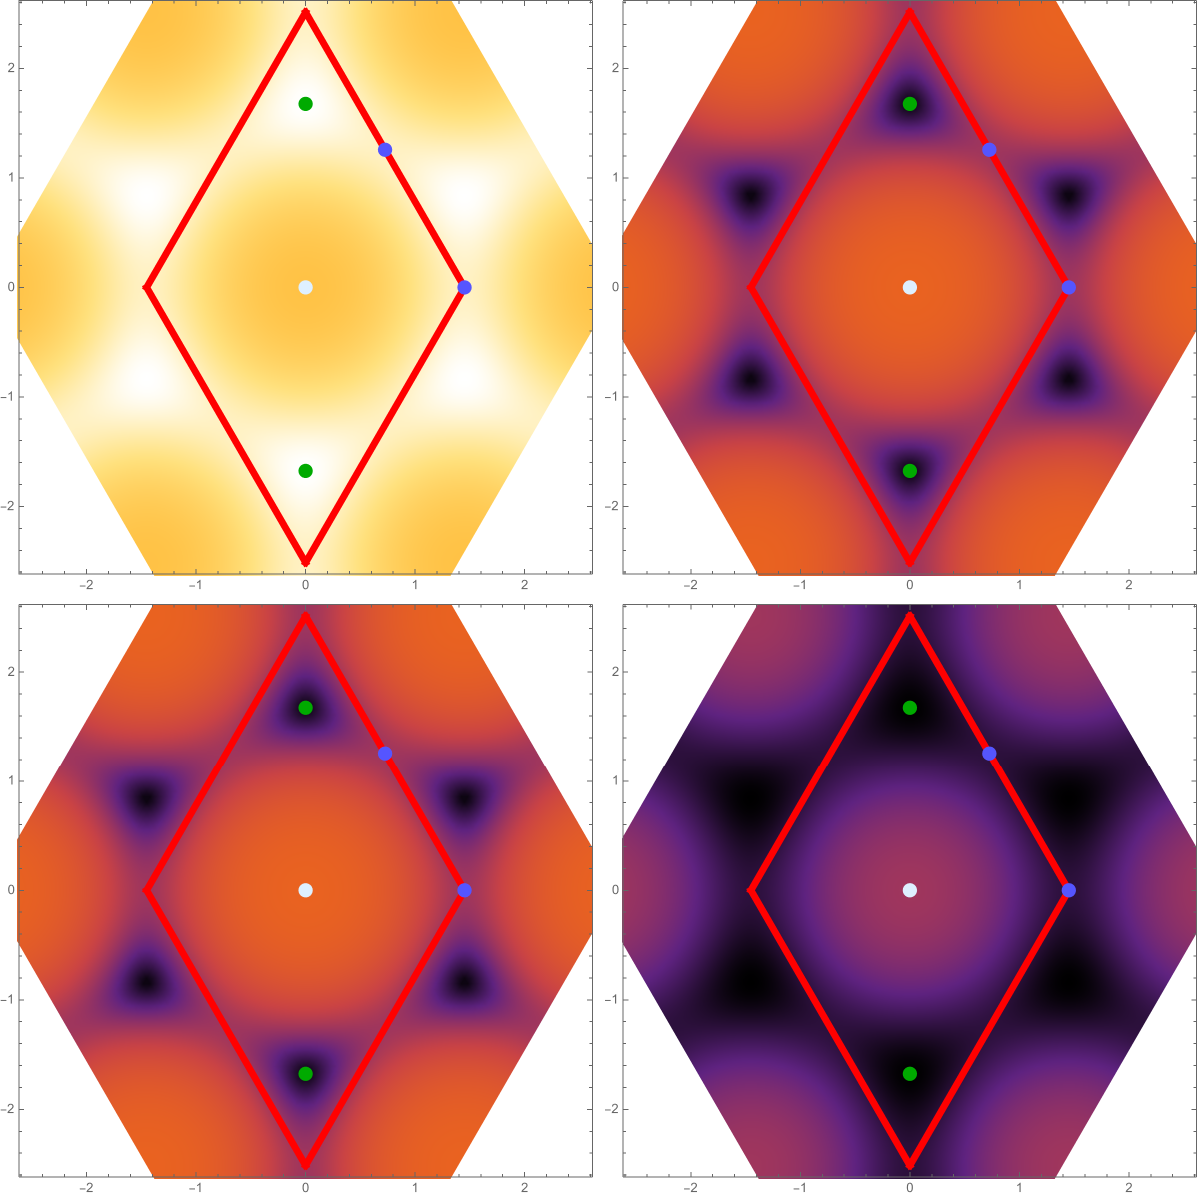

In [ ]:
 GraphicsGrid[Table[
    Show[{
       ListDensityPlot[
        {
          tiled[[6]][[i, j]] 
         } 
        , ImageSize -> 350, ColorFunction -> "SunsetColors", ColorFunctionScaling -> False, Ticks -> {Automatic, Automatic, None}, PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], corner3[[2]]}, Full}] , 
       lattice 
      }] 
    , {i, 1, numbands}, {j, 1, numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]]

### export to pdf

In [ ]:
Do[
 If[
  FileExistsQ["./DensityMatrix_k/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf"], , 
  Block[{plts}, 
   plts = GraphicsGrid[
     Table[
     Show[{
     ListDensityPlot[
     {tiled[[step]][[i, j]]},
     ImageSize -> 350, ColorFunction -> "SunsetColors", ColorFunctionScaling -> True, Ticks -> {Automatic, Automatic, None}, PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], corner3[[2]]}, Full}]
     , lattice}]
     , {i, 1, numbands}, {j, 1, numbands}]
     , ImageSize -> 900, Spacings -> Scaled[0.025]];
   Export["./DensityMatrix_k/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf", Style[plts, Background -> White], "AllowRasterization" -> True, ImageResolution -> 800];]
  ]
 , {step, 1, Length[densmat]}]

## DensityMatrix_k_bloch

### DensityMatrix_k_bloch in time steps

In [60]:
densmatbloch = ParallelTable[Flatten[Table[Import[tt, "DensityMatrix_k_bloch/" <> ToString[step] <> "/" <> ToString[i - 1] <> "/local"], {i, 1, ncom}]], {step, timetab[[All, 1]]}]; // AbsoluteTiming
reimdensmatbloch = ParallelTable[Partition[densmatbloch[[step]], 2] /. {x_, y_} -> {x + I y}, {step, 1, Length[densmatbloch]}]; // AbsoluteTiming
reshapeddensmatbloch = ArrayReshape[reimdensmatbloch, {Length[densmatbloch], numkpts, numbands, numbands}]; // AbsoluteTiming
absdenmatbloch = Abs@reshapeddensmatbloch; // AbsoluteTiming

Length[reshapeddensmatbloch]

11

### integrated DensityMatrix_k_bloch in FBZ

In [ ]:

populationtot = ParallelTable[{0.024188843*timetab[[All, 2]][[step]], Total[absdenmatbloch[[step]][[All, a, b]]]/numkpts}, {step, 1, Length[densmatbloch]}, {a, 1, numbands}, {b, 1, numbands}];

normalization = Table[1 , {i, 1, numbands}, {j, 1, numbands}];

(*normalization = Table[Max[populationtot[[All, i, j]][[All, 2]]] , {i, 1, numbands}, {j, 1, numbands}];*)

normpopulation = Table[populationtot[[All, i, j]] /. {x_, y_} -> {x, y/normalization[[i,j]]}, {i, 1, numbands}, {j, 1, numbands}]

In [ ]:
GraphicsGrid[
 Table[
 ListLinePlot[normpopulation[[All, i, j]], ImageSize -> 400, PlotRange -> {{0, 5}, Automatic}, Ticks -> {Automatic, Automatic, None}, Frame -> True]
 , {i, 1, numbands}, {j, 1, numbands}]
 , ImageSize -> 1000, Spacings -> Scaled[0.025]]

In [ ]:

Block[{plts}, 
   plts = GraphicsGrid[
   Table[
   ListLinePlot[normpopulation[[All, i, j]], ImageSize -> 400, PlotRange -> {{0, 5}, Automatic}, Ticks -> {Automatic, Automatic, None}, Frame -> True]
   , {i, 1, numbands}, {j, 1, numbands}]
   , ImageSize -> 1000, Spacings -> Scaled[0.025]];
   Export["./population_time.pdf", Style[plts, Background -> White], "AllowRasterization" -> True, ImageResolution -> 800];
]

### tiled DensityMatrix_k_bloch

In [ ]:
tiledbloch = ParallelTable[
   Module[{popkptscond},
    popkptscond[a_, b_] := Table[{kptstrans[[i, 1]], kptstrans[[i, 2]], absdenmatbloch[[step]][[i, a, b]]}, {i, 1, Length[kpts]}];
    Table[Join[{bb1vec + bb2vec}, Flatten[Table[popkptscond[a, b] + Threaded[shift[[i]]], {i, 1, Length[shift]}], 1]], {a, 1, numbands}, {b, 1, numbands}]
    ]
   , {step, 1, Length[densmatbloch]}];

-Graphics-
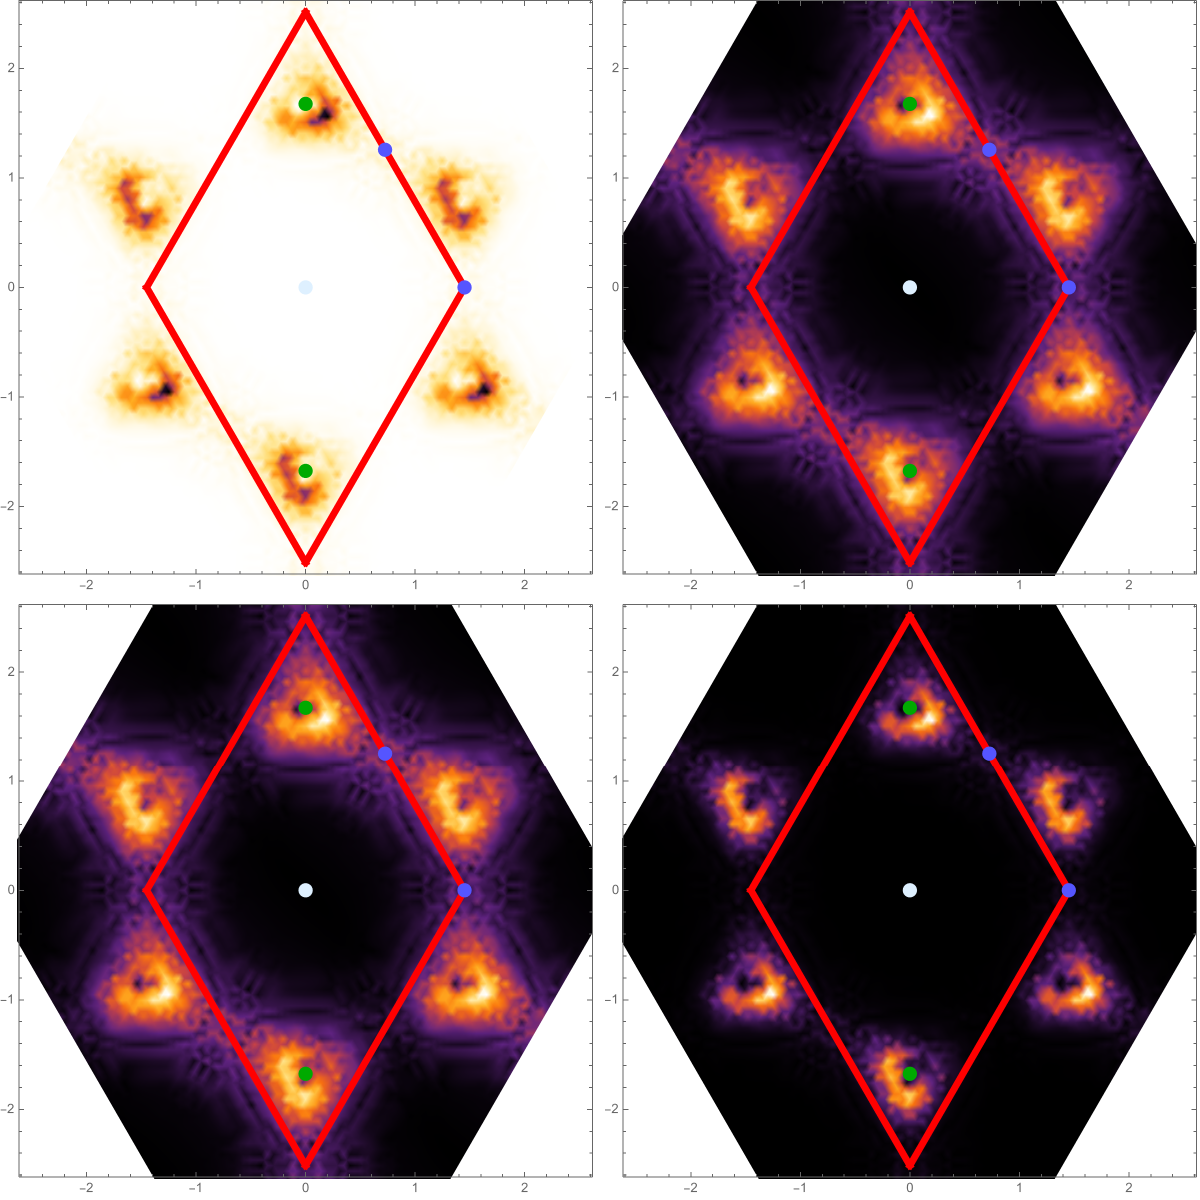

In [ ]:
GraphicsGrid[
 Table[
  Show[{
  ListDensityPlot[{tiledbloch[[(step) /. step -> 6]][[i, j]]}
  , ImageSize -> 350, ColorFunction -> "SunsetColors", ColorFunctionScaling -> True, Ticks -> {Automatic, Automatic, None}, PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], corner3[[2]]}, Full}]
     , lattice
     }]
     , {i, 1, numbands}, {j, 1, numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]]

### export to pdf

In [ ]:
Do[
 If[FileExistsQ["./DensityMatrix_k_bloch/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf"]
  ,  , 
  Block[{plts}, 
   plts = GraphicsGrid[
     Table[Show[{ListDensityPlot[{tiledbloch[[step]][[i, j]]}, 
         ImageSize -> 350, ColorFunction -> "SunsetColors", 
         ColorFunctionScaling -> True, 
         Ticks -> {Automatic, Automatic, None}, 
         PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], 
            corner3[[2]]}, Full}], lattice}], {i, 1, numbands}, {j, 1,
        numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]];
   Export[
    "./DensityMatrix_k_bloch/it" <> 
     ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> 
     ToString[timetab[[All, 2]][[step]]] <> ".pdf", 
    Style[plts, Background -> White], "AllowRasterization" -> True, 
    ImageResolution -> 800];]
  ]
 , {step, 1, Length[densmatbloch]}]

## fullH

### fullH in time steps

In [66]:
hammat = ParallelTable[Flatten[Table[Import[tt, "fullH/" <> ToString[step] <> "/" <> ToString[i - 1] <> "/local"], {i, 1, ncom}]], {step, timetab[[All, 1]]}]; // AbsoluteTiming
reimhammat = ParallelTable[Partition[hammat[[step]], 2] /. {x_, y_} -> {x + I y}, {step, 1, Length[hammat]}]; // AbsoluteTiming
reshapedHamMat = ArrayReshape[reimhammat, {Length[hammat], numkpts, numbands, numbands}]; // AbsoluteTiming
absHamMat = Abs@reshapedHamMat; // AbsoluteTiming

Length[reshapedHamMat]

11

### tiled fullH

In [ ]:
tiledHam = ParallelTable[
   Module[{popkptscond},
    popkptscond[a_, b_] := Table[{kptstrans[[i, 1]], kptstrans[[i, 2]], absHamMat[[step]][[i, a, b]]}, {i, 1, Length[kpts]}];
    Table[Join[{bb1vec + bb2vec}, Flatten[Table[popkptscond[a, b] + Threaded[shift[[i]]], {i, 1, Length[shift]}], 1]], {a, 1, numbands}, {b, 1, numbands}]
    ]
   , {step, 1, Length[hammat]}];

-Graphics-
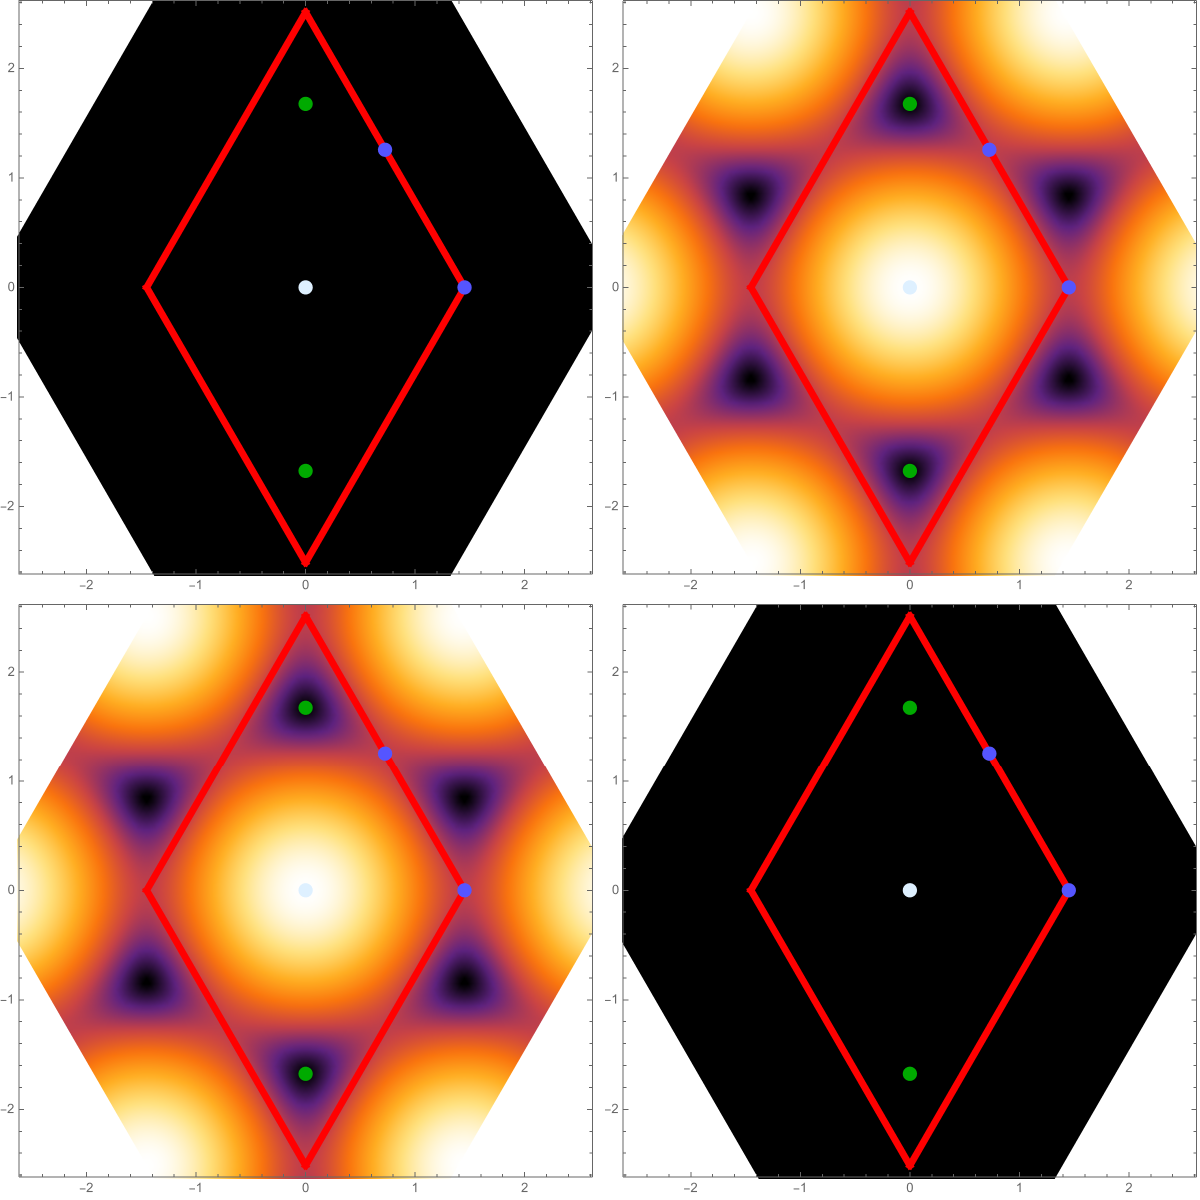

In [ ]:
GraphicsGrid[
 Table[
  Show[{ListDensityPlot[{tiledHam[[(step) /. step -> 6]][[i, j]]},
      ImageSize -> 350, ColorFunction -> "SunsetColors", 
     ColorFunctionScaling -> True, 
     Ticks -> {Automatic, Automatic, None}, 
     PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], 
        corner3[[2]]}, Full}], lattice}], {i, 1, numbands}, {j, 1, 
   numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]]

### export to pdf

In [ ]:
Do[
 If[FileExistsQ["./fullH/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf"]
  ,  , 
  Block[{plts}, 
   plts = GraphicsGrid[
     Table[Show[{ListDensityPlot[{tiledHam[[step]][[i, j]]}, 
         ImageSize -> 350, ColorFunction -> "SunsetColors", 
         ColorFunctionScaling -> True, 
         Ticks -> {Automatic, Automatic, None}, 
         PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], 
            corner3[[2]]}, Full}], lattice}], {i, 1, numbands}, {j, 1,
        numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]];
   Export["./fullH/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf", Style[plts, Background -> White], "AllowRasterization" -> True, ImageResolution -> 800];]
  ]
 , {step, 1, Length[hammat]}]

## SelfEnergy

### SelfEnergy in time steps

In [73]:
selfener = ParallelTable[Flatten[Table[Import[tt, "SelfEnergy/" <> ToString[step] <> "/" <> ToString[i - 1] <> "/local"], {i, 1, ncom}]], {step, timetab[[All, 1]]}]; // AbsoluteTiming
reimselfener = ParallelTable[Partition[selfener[[step]], 2] /. {x_, y_} -> {x + I y}, {step, 1, Length[selfener]}]; // AbsoluteTiming
reshapedselfener = ArrayReshape[reimselfener, {Length[selfener], numkpts, numbands, numbands}]; // AbsoluteTiming
absselfenerg = Abs@reshapedselfener; // AbsoluteTiming

Length[reshapedselfener]

11

### tiled SelfEnergy

In [ ]:
tiledSE = ParallelTable[
   Module[{popkptscond},
    popkptscond[a_, b_] := 
     Table[{kptstrans[[i, 1]], kptstrans[[i, 2]], absselfenerg[[step]][[i, a, b]]}, {i, 1, Length[kpts]}];
    Table[Join[{bb1vec + bb2vec}, Flatten[Table[popkptscond[a, b] + Threaded[shift[[i]]], {i, 1, Length[shift]}], 1]], {a, 1, numbands}, {b, 1, numbands}]
    ]
   , {step, 1, Length[selfener]}];

-Graphics-
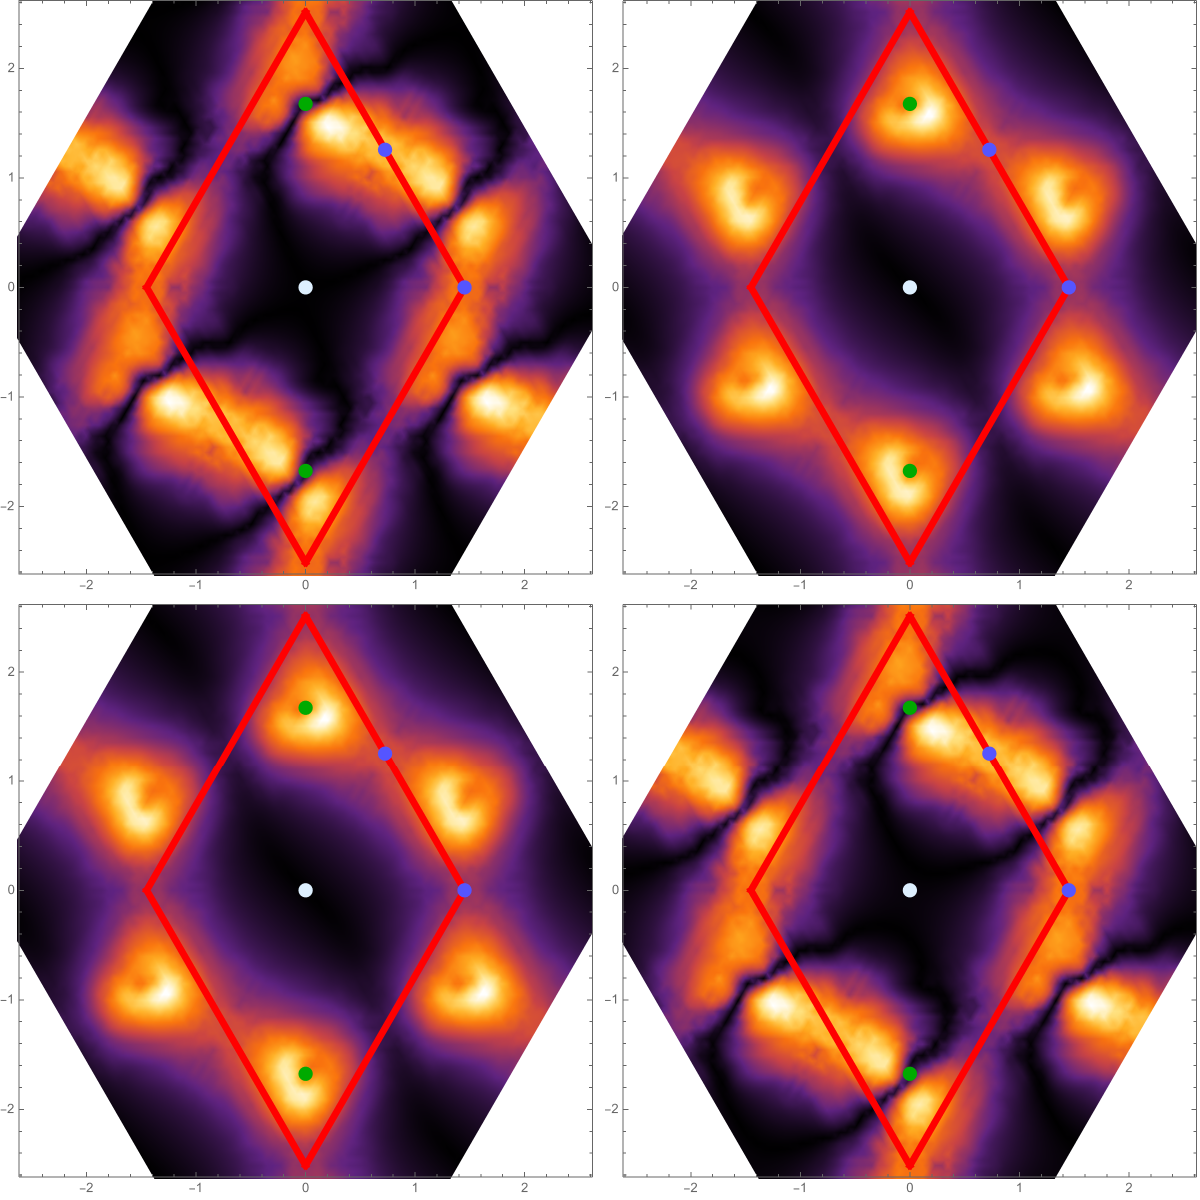

In [ ]:
GraphicsGrid[
 Table[
  Show[{
  ListDensityPlot[{tiledSE[[(step) /. step -> 6]][[i, j]]}, ImageSize -> 350, ColorFunction -> "SunsetColors", ColorFunctionScaling -> True, Ticks -> {Automatic, Automatic, None}, 
     PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], corner3[[2]]}, Full}]
     , lattice
     }]
     , {i, 1, numbands}, {j, 1, numbands}]
     , ImageSize -> 900, Spacings -> Scaled[0.025]]

### export to pdf

In [ ]:
Do[
 If[
  FileExistsQ["./SelfEnergy/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf"],  , 
  Block[{plts}, 
   plts = GraphicsGrid[
     Table[Show[{
     ListDensityPlot[{tiledSE[[step]][[i, j]]}, 
         ImageSize -> 350, ColorFunction -> "SunsetColors", 
         ColorFunctionScaling -> True, 
         Ticks -> {Automatic, Automatic, None}, 
         PlotRange -> {{-corner3[[2]], corner3[[2]]}, {-corner3[[2]], corner3[[2]]}, Full}]
         , lattice
         }]
         , {i, 1, numbands}, {j, 1, numbands}], ImageSize -> 900, Spacings -> Scaled[0.025]];
   Export["./SelfEnergy/it" <> ToString[timetab[[All, 1]][[step]]] <> "_time-au_" <> ToString[timetab[[All, 2]][[step]]] <> ".pdf", Style[plts, Background -> White], "AllowRasterization" -> True, ImageResolution -> 800];
   Clear[plts, tiledSE[[step]]]]
  ]
 , {step, 1, Length[selfener]}]